In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sudoku_solver import filter_image

%matplotlib inline



def line_intersect(A1, A2, B1, B2):
    # https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines-in-python
    def slope(P1, P2):
        return(P2[1] - P1[1]) / (P2[0] - P1[0])

    def y_intercept(P1, slope):
        return P1[1] - slope * P1[0]
   
    m1, m2 = slope(A1, A2), slope(B1, B2)
    if m1 == m2:
        print ("These lines are parallel!!!")
        return None
    
    b1, b2, = y_intercept(A1, m1), y_intercept(B1, m2)
    
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return x,y


def rho_theta_to_coords(line, image_shape=None):
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))

    return x1, y1, x2, y2

def nearest_neighbors(arr, values):
    res = []
#     vs = list(np.sort(values))
    vs = values
    thresholds = list((vs[i+1]+vs[i])/2 for i in range(len(vs)-1))
#     thresholds.insert(0, np.min(arr)*(1+np.finfo(type(arr[0])).eps))
    thresholds.insert(0, np.min(arr)-0.01)

#     print(np.finfo(type(arr[0])).epsneg, np.min(arr),
#           np.min(arr)*(1+np.finfo(type(arr[0])).eps),
#           np.min(arr)<np.min(arr)*(1+np.finfo(type(arr[0])).eps))
    thresholds.append(np.max(arr))
#     print(thresholds)
    for th_i in range(1, len(thresholds)):
#         print(thresholds[th_i-1], thresholds[th_i])
        indexes_1 = np.where(arr<=thresholds[th_i])[0]
        indexes_2 = np.where(arr>thresholds[th_i-1])[0]
        indexes = list(set(indexes_1).intersection(indexes_2))
        res.append(indexes)
    return res

def classify_lines_by_theta(ls):
    thetas = np.array(list(line[0][1] for line in ls))
#     print(len(thetas))
#     plt.hist(thetas)
    count, ths = np.histogram(thetas)
#     print(count)
#     print( np.argsort(count))
    th1, th2 = ths[((np.argsort(count))[::-1])[:2]]
#     print(th1, th2)

    thetas_1, thetas_2 = nearest_neighbors(thetas, [th1, th2])
    
    return ls[thetas_1], ls[thetas_2]

def filter_lines_by_rho(ls, threshold = 25):
    rhos = np.array(list(line[0][0] for line in ls))
    
    sorted_indexes = np.argsort(rhos)
    rhos = rhos[sorted_indexes]
    sorted_lines = ls[sorted_indexes]
#     print(len(rhos), rhos)
    ct = np.array(list(np.array([abs(rhos[i]-rhos[j]) for i in range(len(rhos)-1, j, -1)]) for j in range(len(rhos)-1)))
#     for i, _ in enumerate(ct):
#         print(i, _)
    res = []
    for i, l in enumerate(ct):
        if np.min(l)>threshold:
            res.append(i)
#         else:
#             print("delele", i)
    res.append(len(rhos)-1)
#     print("res", res)
#     print("rhos\n",rhos, "\n")
    classified_lines = nearest_neighbors(rhos, rhos[res])
#     print("classified_lines\n", classified_lines)
#     for _ in list(sorted_lines[inds] for inds in classified_lines):
#         print(_, "end")
    final_lines = list(np.average(sorted_lines[inds], axis=0) for inds in classified_lines)
#     print("test")
#     print(final_lines)
    return final_lines

def detection(img, n_first_lines=50):
    lines = cv2.HoughLines(img, 1, np.pi/180, 30)[:50]
    lines_1, lines_2 = classify_lines_by_theta(lines)
    lines_1, lines_2 = filter_lines_by_rho(lines_1), filter_lines_by_rho(lines_2)
    
    return lines_1, lines_2

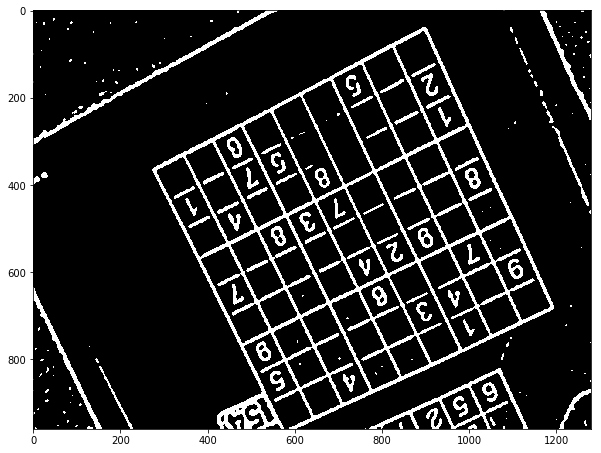

In [2]:
path = "pics/test11.jpg"
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE )

filtered_img = filter_image(img)
plt.figure(figsize=(10,10))
plt.imshow(filtered_img, cmap="gray")
plt.show()

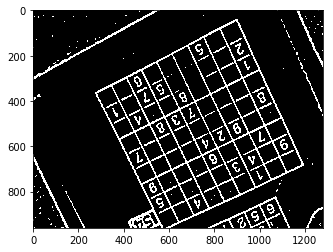

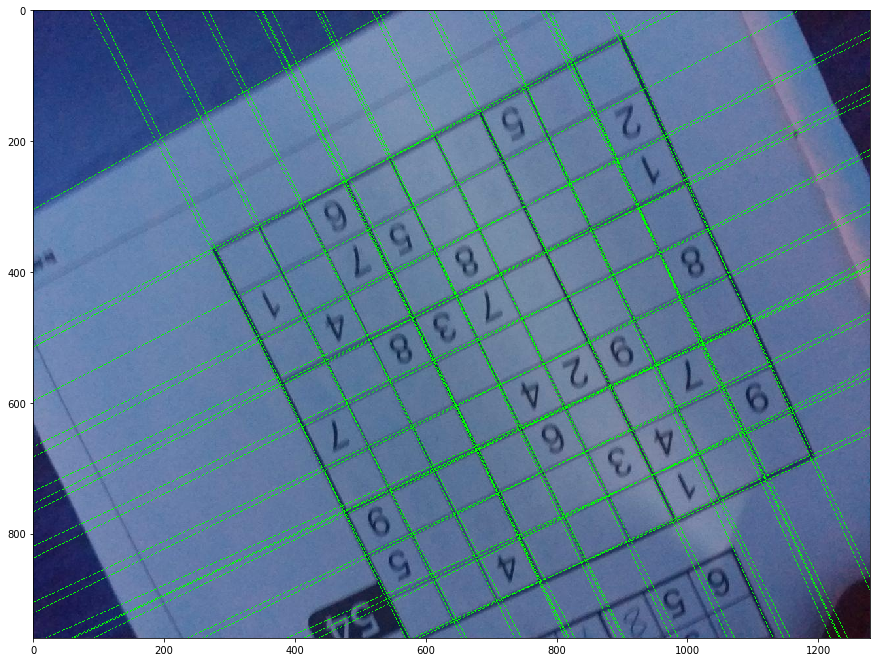

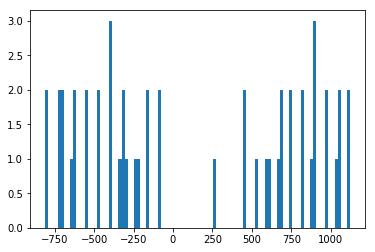

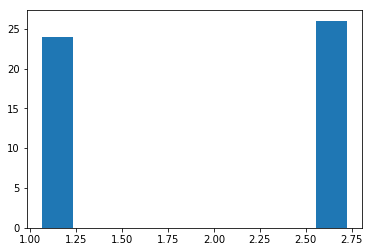

In [3]:
plt.imshow(filtered_img, cmap="gray")
plt.show()

lines = cv2.HoughLines(filtered_img, 1, np.pi/180, 30)
# lines = filter_lines(lines)

rgb_img = cv2.imread(path)
# rgb_img = np.ones((filtered_img.shape[0], filtered_img.shape[1], 3))
# for i in range(rgb_img.shape[0]):
#     for j in range(rgb_img.shape[1]):
#         rgb_img[i][j] = [filtered_img[i][j]]*3

lines = lines[:50]
for line in lines:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    
#     cv2.circle(rgb_img,(x1,y1), 1, (0,0,255), -1)
#     cv2.circle(rgb_img,(x2,y2), 1, (0,0,255), -1)

plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()

plt.hist(np.array(list(line[0][0] for line in lines)), bins=100)
plt.show()
plt.hist(np.array(list(line[0][1] for line in lines)))
plt.show()


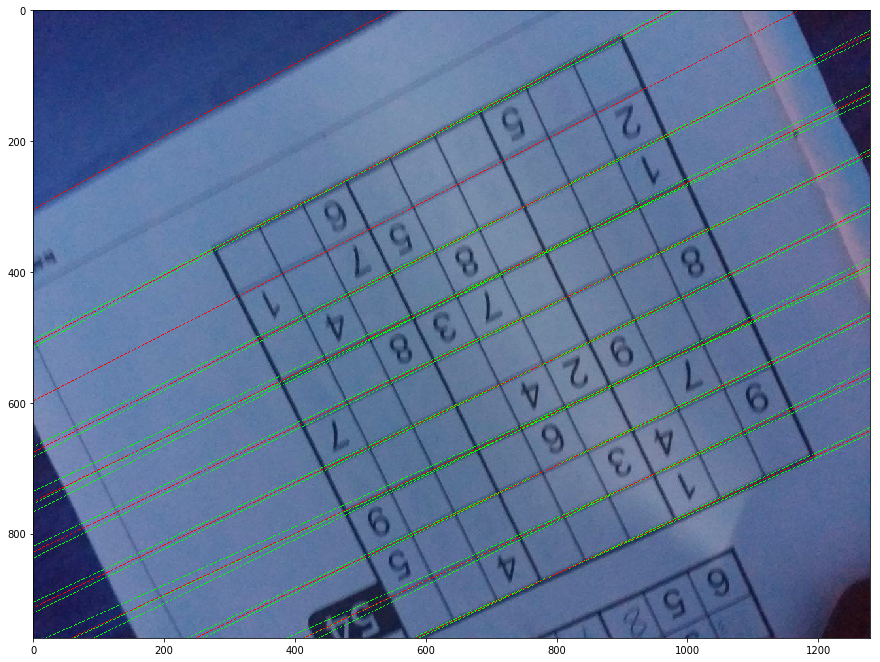

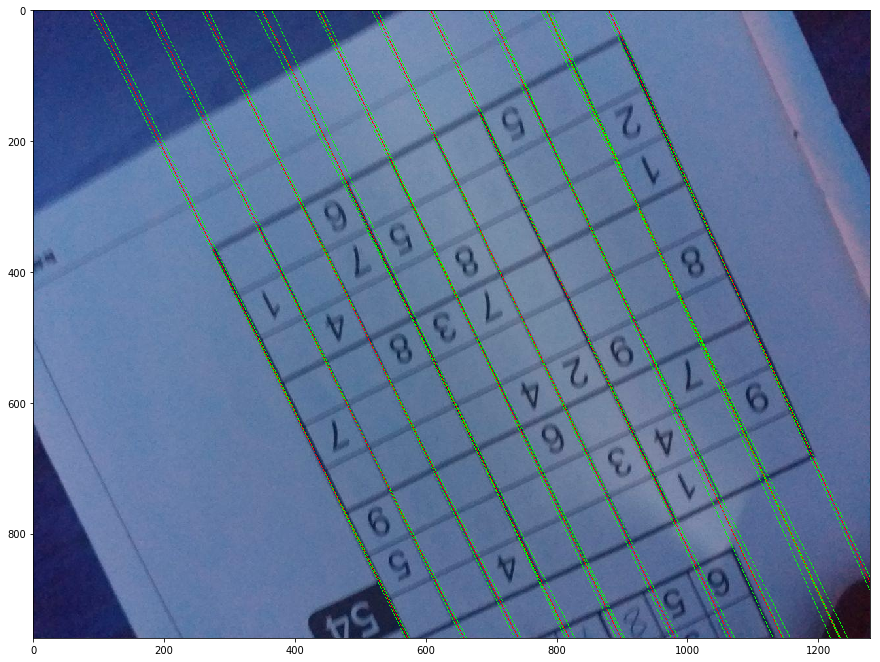

In [4]:
lines_1, lines_2 = classify_lines_by_theta(lines)

rgb_img = cv2.imread(path)
for line in lines_1:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
for line in filter_lines_by_rho(lines_1):
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()


rgb_img = cv2.imread(path)
for line in lines_2:
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
for line in filter_lines_by_rho(lines_2):
    line = line[0]
    x1, y1, x2, y2 = rho_theta_to_coords(line)
    cv2.line(rgb_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()



[-801.0, -711.5, -632.3333, -549.5, -472.0, -394.33334, -316.0, -235.0, -161.0, -84.0]
[89.5, 79.16669, 82.83331, 77.5, 77.66666, 78.33334, 81.0, 74.0, 77.0]


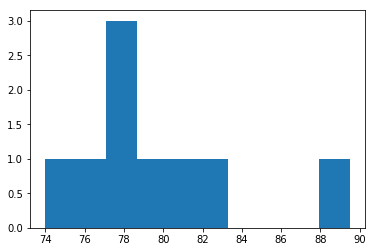

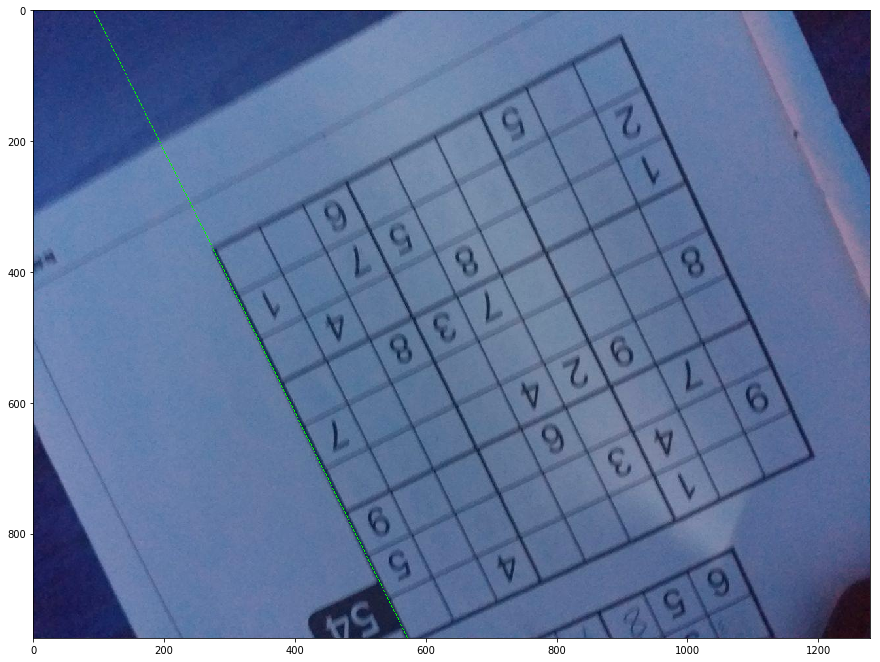

In [8]:
lines_1, lines_2 = classify_lines_by_theta(lines)
l1 = filter_lines_by_rho(lines_1)
l2 = filter_lines_by_rho(lines_2)

rhos = list(l[0][0] for l in l2)
print(rhos)
dr = list(rhos[i]-rhos[i-1] for i in range( len(rhos)))
print(dr)
plt.hist(dr)


rgb_img = cv2.imread(path)
for line in np.concatenate((l1, l2)):
    line = line[0]
    
    cv2.line(rgb_img, (x1, y1), (x2, y2), (0, 255, 0), 1)

plt.figure(figsize=(15, 15))
plt.imshow(rgb_img)
plt.show()